# NLP Clissification
---
**Dataset:** bbc news (250 samples) News contents with 5 categories (Sport, Business, Politics, Tech and Others)

**Model:**   multiclass classification model : Fine-tuning with BERT (https://github.com/google-research/bert/blob/master/README.md)

**Training:**  Colab (GPU)  tensorflow version : 1.14.0  keras version : 2.2.4

**Process:**  1. Dataset Load  ➔ 2. Data processing ➔ 3. Model Training  ➔ 4. Model Evaluation  ➔ 5. Prediction

**Result:** Accuracy  = 0.95, run time = 2 minutes|


## 0. Environment

In [1]:
# Based Library
import tensorflow as tf; print("tensorflow version : " + tf.__version__)
import keras; print("keras version : " + keras.__version__)

tensorflow version : 1.14.0
keras version : 2.2.4


Using TensorFlow backend.


In [2]:
# Processor

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6970865675784502038
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7297709145912744821
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1535537547542774339
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14771804570
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6099636359709851449
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## 1. Dataset Load

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# intent, unique_intent, sentencesに分ける
import pandas as pd

def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
  print(df.head())
  intent = df["Intent"]
  unique_intent = list(set(intent))
  sentences = list(df["Sentence"])
  
  return (df, intent, unique_intent, sentences)

In [5]:
# データ読み込

dataset = "/content/drive/My Drive/dataset/chat_intent1/Dataset.csv"
data, intent, unique_intent, sentences = load_dataset(dataset)

                Sentence          Intent
0       Need help pleese  commonQ.assist
1              Need help  commonQ.assist
2       I need some info  commonQ.assist
3      Will you help me?  commonQ.assist
4  What else can you do?  commonQ.assist


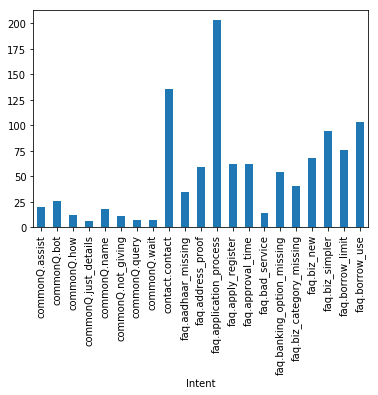

In [6]:
import matplotlib.pyplot as plt

data.groupby('Intent').Sentence.count().plot.bar(ylim=0)
plt.show()

## 2. Data Processing

In [7]:
# Download Bert Requirements

!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!wget https://raw.githubusercontent.com/google-research/bert/master/modeling.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/optimization.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/run_classifier.py 
!wget https://raw.githubusercontent.com/google-research/bert/master/tokenization.py 

--2019-07-27 12:32:57--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c01::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.2’

uncased_L-12_H-768_ 100%[===================>] 388.84M   196MB/s    in 2.0s    

2019-07-27 12:32:59 (196 MB/s) - ‘uncased_L-12_H-768_A-12.zip.2’ saved [407727028/407727028]

--2019-07-27 12:33:01--  https://raw.githubusercontent.com/google-research/bert/master/modeling.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37922 (37K) 

In [0]:
from sklearn.preprocessing import LabelEncoder

df = pd.DataFrame()
df["text"] = data["Sentence"]
df["label"] = LabelEncoder().fit_transform(data["Intent"])

In [9]:
df.head()

,text,label
0,Need help pleese,0
1,Need help,0
2,I need some info,0
3,Will you help me?,0
4,What else can you do?,0


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df["text"].values, df["label"].values, test_size=0.2, random_state=42)

## 3. Model Training

In [11]:
import modeling
import optimization
import run_classifier
import tokenization
import zipfile

folder = 'model_folder'
with zipfile.ZipFile("uncased_L-12_H-768_A-12.zip","r") as zip_ref:
    zip_ref.extractall(folder)

W0727 12:33:13.807945 140359431710592 deprecation_wrapper.py:119] From /content/optimization.py:87: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [12]:
BERT_MODEL = 'uncased_L-12_H-768_A-12'
BERT_PRETRAINED_DIR = f'{folder}/uncased_L-12_H-768_A-12'
OUTPUT_DIR = f'{folder}/outputs'

print(f'>> Model output directory: {OUTPUT_DIR}')
print(f'>>  BERT pretrained directory: {BERT_PRETRAINED_DIR}')

>> Model output directory: model_folder/outputs
>>  BERT pretrained directory: model_folder/uncased_L-12_H-768_A-12


In [13]:
import os
import tensorflow as tf
from datetime import datetime

start_time = datetime.now()

def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5  # 0.00001
NUM_TRAIN_EPOCHS = 3.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 50
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000
NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

label_list = [str(num) for num in range(len(unique_intent))]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
# None for CPU or GPU
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0727 12:33:18.330802 140359431710592 deprecation_wrapper.py:119] From /content/tokenization.py:125: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

W0727 12:33:19.244402 140359431710592 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0727 12:33:19.246710 140359431710592 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7fa747e55950>) includes params argument, but params are not passed to Estimator.
W0727 12:33:19.251060 140359431710592 tpu_context.py:211] eval_on_tpu ignored because use_tpu is False.


Duration: 0:00:00.921808


In [14]:
import datetime

start_time = datetime.datetime.now()

print('Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

end_time = datetime.datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0727 12:33:19.267831 140359431710592 deprecation_wrapper.py:119] From /content/run_classifier.py:774: The name tf.logging.info is deprecated. Please use tf.compat.v1.logging.info instead.



Please wait...
>> Started training at 2019-07-27 12:33:19.424872 
  Num examples = 890
  Batch size = 32
>> Finished training at 2019-07-27 12:33:19.437680
Duration: 0:00:00.170181


In [15]:
from datetime import datetime
start_time = datetime.now()

def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    batch_size = 500

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.000209


## 5. Model Evaluation

In [0]:
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

In [17]:
import numpy as np
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))
print(len(preds))

W0727 12:33:19.618649 140359431710592 deprecation_wrapper.py:119] From /content/modeling.py:171: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0727 12:33:19.621278 140359431710592 deprecation_wrapper.py:119] From /content/modeling.py:409: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



{}


W0727 12:33:19.779204 140359431710592 deprecation_wrapper.py:119] From /content/modeling.py:490: The name tf.assert_less_equal is deprecated. Please use tf.compat.v1.assert_less_equal instead.

W0727 12:33:19.837111 140359431710592 deprecation.py:323] From /content/modeling.py:671: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0727 12:33:22.283314 140359431710592 deprecation_wrapper.py:119] From /content/run_classifier.py:647: The name tf.trainable_variables is deprecated. Please use tf.compat.v1.trainable_variables instead.

W0727 12:33:22.286646 140359431710592 deprecation_wrapper.py:119] From /content/run_classifier.py:661: The name tf.train.init_from_checkpoint is deprecated. Please use tf.compat.v1.train.init_from_checkpoint instead.

W0727 12:33:23.032752 140359431710592 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/array_ops.py:1

223


In [18]:
from sklearn.metrics import accuracy_score

print("Accuracy of BERT is:",accuracy_score(y_test,preds))

Accuracy of BERT is: 0.9506726457399103


In [19]:
from sklearn.metrics import classification_report

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         5
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      0.88      0.93        24
           9       0.75      1.00      0.86         6
          10       1.00      1.00      1.00        13
          11       0.95      0.95      0.95        42
          12       0.93      0.87      0.90        15
          13       0.86      1.00      0.92         6
          14       0.67      1.00      0.80         2
          15       0.87      1.00      0.93        13
          16       1.00      1.00      1.00         7
          17       0.94    

## 6. Parameter Tunining

In [20]:
import os
import tensorflow as tf
from datetime import datetime

start_time = datetime.now()

def create_examples(lines, set_type, labels=None):
#Generate data for the BERT model
    guid = f'{set_type}'
    examples = []
    if guid == 'train':
        for line, label in zip(lines, labels):
            text_a = line
            label = str(label)
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    else:
        for line in lines:
            text_a = line
            label = '0'
            examples.append(
              run_classifier.InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
    return examples

# Model Hyper Parameters
TRAIN_BATCH_SIZE = 32
EVAL_BATCH_SIZE = 8
LEARNING_RATE = 1e-5
NUM_TRAIN_EPOCHS = 20.0
WARMUP_PROPORTION = 0.1
MAX_SEQ_LENGTH = 50
# Model configs
SAVE_CHECKPOINTS_STEPS = 100000 #if you wish to finetune a model on a larger dataset, use larger interval
# each checpoint weights about 1,5gb
ITERATIONS_PER_LOOP = 100000

NUM_TPU_CORES = 8
VOCAB_FILE = os.path.join(BERT_PRETRAINED_DIR, 'vocab.txt')
CONFIG_FILE = os.path.join(BERT_PRETRAINED_DIR, 'bert_config.json')
INIT_CHECKPOINT = os.path.join(BERT_PRETRAINED_DIR, 'bert_model.ckpt')
DO_LOWER_CASE = BERT_MODEL.startswith('uncased')

label_list = [str(num) for num in range(len(unique_intent))]
tokenizer = tokenization.FullTokenizer(vocab_file=VOCAB_FILE, do_lower_case=DO_LOWER_CASE)
train_examples = create_examples(X_train, 'train', labels=y_train)

tpu_cluster_resolver = None #Since training will happen on GPU, we won't need a cluster resolver
# None for CPU or GPU
#TPUEstimator also supports training on CPU and GPU. You don't need to define a separate tf.estimator.Estimator.
run_config = tf.contrib.tpu.RunConfig(
    cluster=tpu_cluster_resolver,
    model_dir=OUTPUT_DIR,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS,
    tpu_config=tf.contrib.tpu.TPUConfig(
        iterations_per_loop=ITERATIONS_PER_LOOP,
        num_shards=NUM_TPU_CORES,
        per_host_input_for_training=tf.contrib.tpu.InputPipelineConfig.PER_HOST_V2))

num_train_steps = int(
    len(train_examples) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

model_fn = run_classifier.model_fn_builder(
    bert_config=modeling.BertConfig.from_json_file(CONFIG_FILE),
    num_labels=len(label_list),
    init_checkpoint=INIT_CHECKPOINT,
    learning_rate=LEARNING_RATE,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available  
    use_one_hot_embeddings=True)

estimator = tf.contrib.tpu.TPUEstimator(
    use_tpu=False, #If False training will fall on CPU or GPU, depending on what is available 
    model_fn=model_fn,
    config=run_config,
    train_batch_size=TRAIN_BATCH_SIZE,
    eval_batch_size=EVAL_BATCH_SIZE)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

W0727 12:33:26.717781 140359431710592 estimator.py:1984] Estimator's model_fn (<function model_fn_builder.<locals>.model_fn at 0x7fa74d73aea0>) includes params argument, but params are not passed to Estimator.
W0727 12:33:26.719397 140359431710592 tpu_context.py:211] eval_on_tpu ignored because use_tpu is False.


Duration: 0:00:00.110612


In [21]:
import datetime

start_time = datetime.datetime.now()

print('Please wait...')
train_features = run_classifier.convert_examples_to_features(
    train_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
print('>> Started training at {} '.format(datetime.datetime.now()))
print('  Num examples = {}'.format(len(train_examples)))
print('  Batch size = {}'.format(TRAIN_BATCH_SIZE))
tf.logging.info("  Num steps = %d", num_train_steps)
train_input_fn = run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=True)
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print('>> Finished training at {}'.format(datetime.datetime.now()))

end_time = datetime.datetime.now()
print('Duration: {}'.format(end_time - start_time))

Please wait...
>> Started training at 2019-07-27 12:33:26.904563 
  Num examples = 890
  Batch size = 32
>> Finished training at 2019-07-27 12:33:26.910640
Duration: 0:00:00.173486


In [22]:
from datetime import datetime

start_time = datetime.now()

def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    print(params)
    batch_size = 500

    num_examples = len(features)

    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 0:00:00.000329


In [0]:
predict_examples = create_examples(X_test, 'test')

predict_features = run_classifier.convert_examples_to_features(
    predict_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

predict_input_fn = input_fn_builder(
    features=predict_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

result = estimator.predict(input_fn=predict_input_fn)

In [24]:
import numpy as np
preds = []
for prediction in result:
      preds.append(np.argmax(prediction['probabilities']))
print(len(preds))

{}
223


In [25]:
from sklearn.metrics import accuracy_score

print("Accuracy of BERT is:",accuracy_score(y_test,preds))

Accuracy of BERT is: 0.9506726457399103


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      1.00      1.00         5
           2       1.00      0.75      0.86         4
           3       1.00      1.00      1.00         3
           4       1.00      1.00      1.00         5
           5       1.00      0.67      0.80         3
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       1.00      0.88      0.93        24
           9       0.75      1.00      0.86         6
          10       1.00      1.00      1.00        13
          11       0.95      0.95      0.95        42
          12       0.93      0.87      0.90        15
          13       0.86      1.00      0.92         6
          14       0.67      1.00      0.80         2
          15       0.87      1.00      0.93        13
          16       1.00      1.00      1.00         7
          17       0.94    